In [1]:
%matplotlib inline

For this tutorial, we use the auditory Brainstorm tutorial dataset [1]_ that is available as a part of the Brainstorm software.

First comes the imports for data i/o and processing, visualization etc.

In [2]:
import os
import numpy as np
import pandas as pd

import mne
from mne.datasets.brainstorm import bst_auditory
from mne.io import read_raw_ctf

import eelbrain
from eelbrain import load, plot

from ncrf import fit_ncrf

## Preprocessing

Preporcess MEG Data, i.e. low pass filtering, power line attenuation, downsampling etc. 
We broadly follow [this tutorial](https://www.nmr.mgh.harvard.edu/mne/stable/auto_tutorials/sample-datasets/plot_brainstorm_auditory.html).

ds directory : /home/proloy/mne_data/MNE-brainstorm-data/bst_auditory/MEG/bst_auditory/S01_AEF_20131218_01.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
       2.51   74.26    0.00 mm <->    2.51   74.26    0.00 mm (orig :  -56.69   50.20 -264.38 mm) diff =    0.000 mm
      -2.51  -74.26    0.00 mm <->   -2.51  -74.26    0.00 mm (orig :   50.89  -52.31 -265.88 mm) diff =    0.000 mm
     108.63    0.00    0.00 mm <->  108.63    0.00    0.00 mm (orig :   67.41   77.68 -239.53 mm) diff =    0.000 mm
    Coordinate transformations established.
    Reading digitizer points from ['/home/proloy/mne_data/MNE-brainstorm-data/bst_auditory/MEG/bst_auditory/S01_AEF_20131218_01.ds/S01_20131218_01.pos']...
    Polhemus data for 3 HPI coils added
    Device coordinate locations for 3 HPI coils added
    5 extra points added to Polhemus data.
    Measurement info composed.
Finding samples for /home/proloy/mne_dat

/home/proloy/mne_data/MNE-brainstorm-data/bst_auditory/MEG/bst_auditory/S01_AEF_20131218_01.ds/S01_AEF_20131218_01.meg4: MNE generated only 233 Epochs for 240 events. The raw file might end before the end of the last epoch.


<NDVar: 270 sensor, 36000 time>


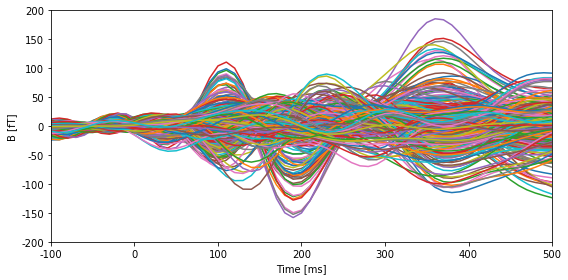

In [3]:
use_precomputed = True 

data_path = bst_auditory.data_path()

raw_fname1 = os.path.join(data_path, 'MEG', 'bst_auditory',
                     'S01_AEF_20131218_01.ds')
# raw_fname2 = os.path.join(data_path, 'MEG', 'bst_auditory',
#                      'S01_AEF_20131218_02.ds')
raw_AEF = read_raw_ctf(raw_fname1, preload=False)
n_times_run1 = raw_AEF.n_times
# mne.io.concatenate_raws([raw_AEF, read_raw_ctf(raw_fname2, preload=False)])
# raw_AEF.plot()

# We mark a set of bad channels that seem noisier than others. 
# The marked channels are added as bad.

raw_AEF.info['bads'] = ['MLO52-4408', 'MRT51-4408', 'MLO42-4408', 'MLO43-4408']

annotations_df = pd.DataFrame()
offset = n_times_run1
for idx in [1]:
    csv_fname = os.path.join(data_path, 'MEG', 'bst_auditory',
                        'events_bad_0%s.csv' % idx)
    df = pd.read_csv(csv_fname, header=None,
                     names=['onset', 'duration', 'id', 'label'])
    print('Events from run {0}:'.format(idx))
    print(df)

    df['onset'] += offset * (idx - 1)
    annotations_df = pd.concat([annotations_df, df], axis=0)

# Conversion from samples to times:
onsets = annotations_df['onset'].values / raw_AEF.info['sfreq']
durations = annotations_df['duration'].values / raw_AEF.info['sfreq']
descriptions = annotations_df['label'].values

annotations = mne.Annotations(onsets, durations, descriptions)
raw_AEF.set_annotations(annotations)
del onsets, durations, descriptions


# events are the presentation times of the audio stimuli: UPPT001
events = mne.find_events(raw_AEF, stim_channel='UPPT001')
# The event timing is adjusted by comparing the trigger times on detected sound onsets on channel UADC001-4408.
sound_data = raw_AEF[raw_AEF.ch_names.index('UADC001-4408')][0][0]
onsets = np.where(np.abs(sound_data) > 2. * np.std(sound_data))[0]
min_diff = int(0.5 * raw_AEF.info['sfreq'])
diffs = np.concatenate([[min_diff + 1], np.diff(onsets)])
onsets = onsets[diffs > min_diff]
assert len(onsets) == len(events)
diffs = 1000. * (events[:, 0] - onsets) / raw_AEF.info['sfreq']
print('Trigger delay removed (μ ± σ): %0.1f ± %0.1f ms'
      % (np.mean(diffs), np.std(diffs)))

# events times are rescaled according to new sampling freq, 100 Hz
events[:, 0] = np.int64(onsets * 100 / raw_AEF.info['sfreq'])
event_fname = os.path.join(data_path, 'MEG', 'bst_auditory',
                     'S01_AEF_20131218_01-eve.fif')
mne.write_events(event_fname, events)

del sound_data, diffs

## set EOG channel
# raw.set_channel_types({'EEG058': 'eog'})
raw_AEF.set_eeg_reference('average', projection=True)
# raw_AEF.plot_psd(tmax=60., average=False)
raw_AEF.load_data()
raw_AEF.notch_filter(np.arange(60, 181, 60), fir_design='firwin')

# band pass filtering 1-8 Hz
raw_AEF.filter(1.0, 8.0, fir_design='firwin')

# resample to 100 Hz
raw_AEF.resample(100, npad="auto")

### LOAD RELEVANT VARIABLES AS eelbrain.NDVar
# load as epochs for plot only
ds = load.fiff.events(raw=raw_AEF, proj=True, stim_channel='UPPT001', events=event_fname)
epochs = load.fiff.epochs(ds, tmin=-0.1, tmax=0.5, baseline=(None, 0))
plot.Butterfly(epochs)

# pick MEG channels
picks = mne.pick_types(raw_AEF.info, meg=True, eeg=False, stim=False, eog=False,
                       ref_meg=False, exclude='bads')

# Read as a single chunk of data
y, t = raw_AEF.get_data(picks, return_times=True)
sensor_dim = load.fiff.sensor_dim(raw_AEF.info, picks=picks)
time = eelbrain.UTS.from_int(0, t.size-1, raw_AEF.info['sfreq'])
meg = eelbrain.NDVar(y, dims=(sensor_dim, time))
print(meg)

## Continuous stimulus variable construction
After loading and processing the raw data, we will construct the predictor variable for this particular experiment (by putting an impulse at every event time-point). Note that, the predictor variable and meg response should be of same length. 

In case of repetative trials (where you will have `eelbrain.cases`), supply one predictor variable for each trial. Different perdictor variables for a single trial can be nested (See README).    

In this example we use two different predictor variables for a single trial

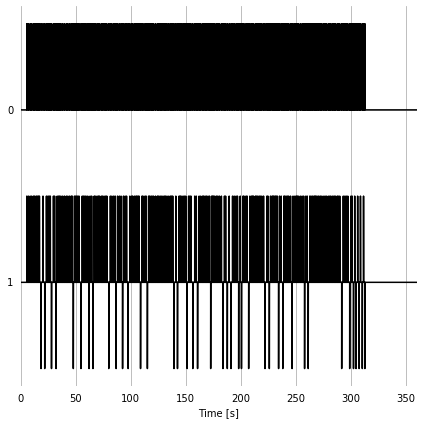

In [4]:
# For the common response we put impulses at the the presentation times of both the audio stimuli (i.e. beeps).
stim1 = np.zeros(len(time), dtype=np.double)
stim1[events[:, 0]] = 1.

# To distingusih between standard and deviant beeps, we assign 1 and -1 impulses respectively.  
stim2 = stim1.copy()
stim2[events[np.where(events[:, 2] == 2), 0]] = -1.
stim1 = eelbrain.NDVar(stim1, time)
stim2 = eelbrain.NDVar(stim2, time)

# visualize the stimulus
s = plot.LineStack(eelbrain.combine([stim1, stim2]))

## Noise covariance estimation
Now we shall estimate the noise covariance from empty room data. Dont forget to apply the same pre-processing steps to empty room data.
instead you can choose to use pre-stimulus recordings to compute noise covariance.

In [5]:
Noise_path = (data_path + '/MEG/bst_auditory/' +
            'S01_Noise_20131218_01.ds')
raw_empty_room = read_raw_ctf(Noise_path, preload=True)

# Apply the same pre-processing steps to empty room data
# raw_empty_room.info['bads'] = [
#     bb for bb in raw_AEF.info['bads'] if 'EEG' not in bb]
# raw_empty_room.add_proj(
#     [pp.copy() for pp in raw_AEF.info['projs'] if 'EEG' not in pp['desc']])

# raw_empty_room.plot_psd(tmax=60., average=False)
raw_empty_room.notch_filter(np.arange(60, 181, 60), fir_design='firwin')

raw_empty_room.filter(1.0, 8.0, fir_design='firwin')

raw_empty_room.resample(100, npad="auto")

# copute noise covariance matrix
noise_cov = mne.compute_raw_covariance(raw_empty_room, tmin=0, tmax=None, method='shrunk', rank=None)

ds directory : /home/proloy/mne_data/MNE-brainstorm-data/bst_auditory/MEG/bst_auditory/S01_Noise_20131218_01.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
       0.00   80.00    0.00 mm <->    0.00   80.00    0.00 mm (orig :  -56.57   56.57 -270.00 mm) diff =    0.000 mm
       0.00  -80.00    0.00 mm <->    0.00  -80.00    0.00 mm (orig :   56.57  -56.57 -270.00 mm) diff =    0.000 mm
      80.00    0.00    0.00 mm <->   80.00   -0.00    0.00 mm (orig :   56.57   56.57 -270.00 mm) diff =    0.000 mm
    Coordinate transformations established.
    Polhemus data for 3 HPI coils added
    Device coordinate locations for 3 HPI coils added
    Measurement info composed.
Finding samples for /home/proloy/mne_data/MNE-brainstorm-data/bst_auditory/MEG/bst_auditory/S01_Noise_20131218_01.ds/S01_Noise_20131218_01.meg4: 
    System clock channel is available, checking which samples are valid.
    15 x 4800 = 72

## Forward Modelling aka lead-field matrix
Now is the time for forward modelling. 'ico-4' or 'vol-10' sould be enough if working with surface source space.
You can choose to work with free / constrained lead field. fit_ncrf will choose appropiate regularizer by looking at the provided lead-field matrix.  

In [6]:
# The paths to Freesurfer reconstructions
subjects_dir = data_path + '/subjects'
subject = 'bst_auditory'

# mne.viz.plot_bem(subject=subject, subjects_dir=subjects_dir,
#                  brain_surfaces='white', orientation='coronal')

# The transformation file obtained by coregistration
trans = data_path + '/MEG/bst_auditory/bst_auditory-trans.fif'

info = raw_AEF.info
# Here we look at the head only.
# mne.viz.plot_alignment(info, trans, subject=subject, dig=True,
#                        meg=['helmet', 'sensors'], subjects_dir=subjects_dir,
#                        surfaces='head')

srcfile = data_path + '/subjects/bst_auditory/bem/bst_auditory-ico-4-src.fif'
if os.path.isfile(srcfile):
    src = mne.read_source_spaces(srcfile)
else:
    src = mne.setup_source_space(subject, spacing='ico4',
                                 subjects_dir=subjects_dir, add_dist=False)
    mne.add_source_space_distances(src)
    mne.write_source_spaces(srcfile, src, overwrite=True)  # needed for smoothing
print(src)

fwdfile = data_path + '/subjects/bst_auditory/bem/bst_auditory-ico-4-fwd.fif'
if os.path.isfile(fwdfile):
    fwd = mne.read_forward_solution(fwdfile)
else:
    ## Compute Forward Solution
    conductivity = (0.3,)  # for single layer
    # conductivity = (0.3, 0.006, 0.3)  # for three layers
    model = mne.make_bem_model(subject=subject, ico=4,
                               conductivity=conductivity,
                               subjects_dir=subjects_dir)
    bem = mne.make_bem_solution(model)

    fwd = mne.make_forward_solution(info, trans=trans, src=src, bem=bem,
                                    meg=True, eeg=False, mindist=5.0, n_jobs=2)
    mne.write_forward_solution(fwdfile, fwd)

print(fwd)

fwd_fixed = mne.convert_forward_solution(fwd, surf_ori=True, force_fixed=True,
                                         use_cps=True)

# leadfield matrix
lf = load.fiff.forward_operator(fwd_fixed, src='ico-4', subjects_dir=subjects_dir)

    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
<SourceSpaces: [<surface (lh), n_vertices=163080, n_used=2562, coordinate_frame=MRI (surface RAS)>, <surface (rh), n_vertices=163816, n_used=2562, coordinate_frame=MRI (surface RAS)>]>
Reading forward solution from /home/proloy/mne_data/MNE-brainstorm-data/bst_auditory/subjects/bst_auditory/bem/bst_auditory-ico-4-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read ME

## NCRF estimation

Now that we have all the required NDvars, we can learn the neuro-current response functions [2]_ from the data. 
For this example we use a fixed mu, but for publication purposes you need to choose mu by cross-validation,
`mu='auto'` takes care of that.

In [7]:
# RUN fit_ncrf algorithm
print('Running source TRF estimation')
args=(meg, [stim1, stim2], lf, noise_cov, 0, 0.8)

mu = 0.001
kwargs = {'normalize': 'l1', 'in_place': False, 'mu': mu,
          'verbose': True, 'n_iter': 5, 'n_iterc': 10, 'n_iterf': 100}

model = fit_ncrf(*args, **kwargs)

Running source TRF estimation


100%|██████████| 5/5 [01:01<00:00, 12.32s/it]


The learned kernel/filter can be accessed as shown below.

In [8]:
h = model.h
print(h) # two sets of NCRFs corresponding to two different stimuli

[<NDVar: 5107 source, 81 time>, <NDVar: 5107 source, 81 time>]


## Visualization
Visualization can be done eelbrain plot functions. We only plot `h[0]` here, please try `h[1]` when you are playing with the code.

### pro tip:
since the estimates are sparse over cortical mantle, you can smooth the ncrfs over sources to make the visualization easy (see third line of the following code).

    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read


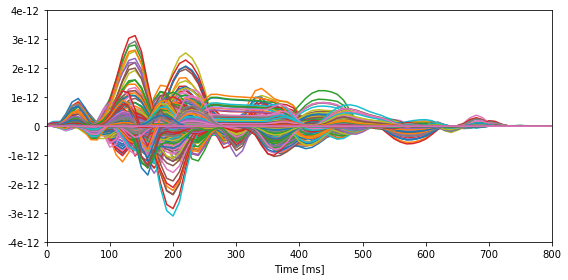

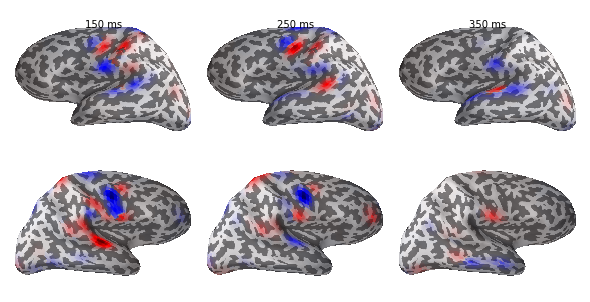

In [9]:
# The following code is for plotting in jupyter notebook, 
# for ipython we can use interactive time-liked plots (commented lines)
h0 = h[0].smooth('source', 0.01, 'gaussian')
p = plot.Butterfly(h0)
# eelbrain.configure(frame=False)
h_binned = h0.bin(0.1, 0.1, 0.4, 'extrema')
sp = plot.brain.SequencePlotter()
sp.set_brain_args(surf='inflated')
sp.add_ndvar(h_binned)
p = sp.plot_table(view='lateral')

## for interactive session
# bp = plot.brain.brain(h[0])

# References
.. [1] Tadel F, Baillet S, Mosher JC, Pantazis D, Leahy RM. Brainstorm: A User-Friendly Application for MEG/EEG Analysis. Computational Intelligence and Neuroscience, vol. 2011, Article ID 879716, 13 pages, 2011. doi:10.1155/2011/879716

.. [2] Das P, Brodbeck C, Simon JZ, Babadi B. Neuro-Current Response Functions: A Unified Approach to MEG Source Analysis under the Continuous Stimuli Paradigm. BioRxiv. 2019. doi:10.1101/761999